In [41]:
'''This script demonstrates how to build a variational autoencoder with Keras.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

# global
nb_epoch = 50

#vae params
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epsilon_std = 1.0

def vae_loss(x, x_decoded_mean):
    xent_loss = original_dim * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,
                              std=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

x = Input(batch_shape=(batch_size, original_dim))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])



# we instantiate these layers separately so as to reuse them later
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


vae = Model(x, x_decoded_mean)
vae.compile(optimizer='rmsprop', loss=vae_loss)

# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [42]:
# ==== dataset handling - train the VAE on MNIST digits ===
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [ ]:
isfit = vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=5,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 5s - loss: 159.8659 - val_loss: 159.5924
Epoch 2/5
60000/60000 [==============================] - 5s - loss: 158.9433 - val_loss: 158.9351
Epoch 3/5
60000/60000 [==============================] - 5s - loss: 158.0854 - val_loss: 158.0534
Epoch 4/5
60000/60000 [==============================] - 5s - loss: 157.3830 - val_loss: 157.5909
Epoch 5/5
11600/60000 [====>.........................] - ETA: 4s - loss: 156.7935

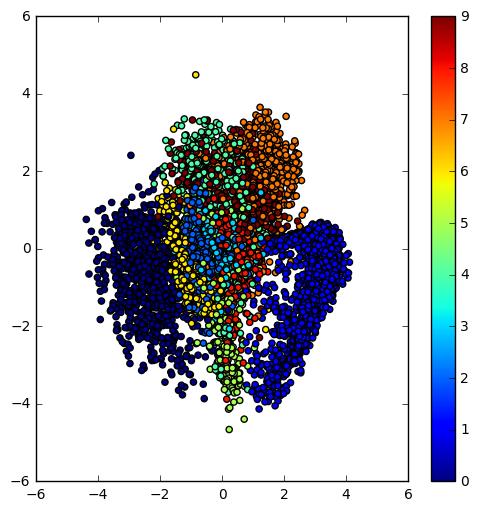

In [45]:
# ===== plotting encoder output
# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

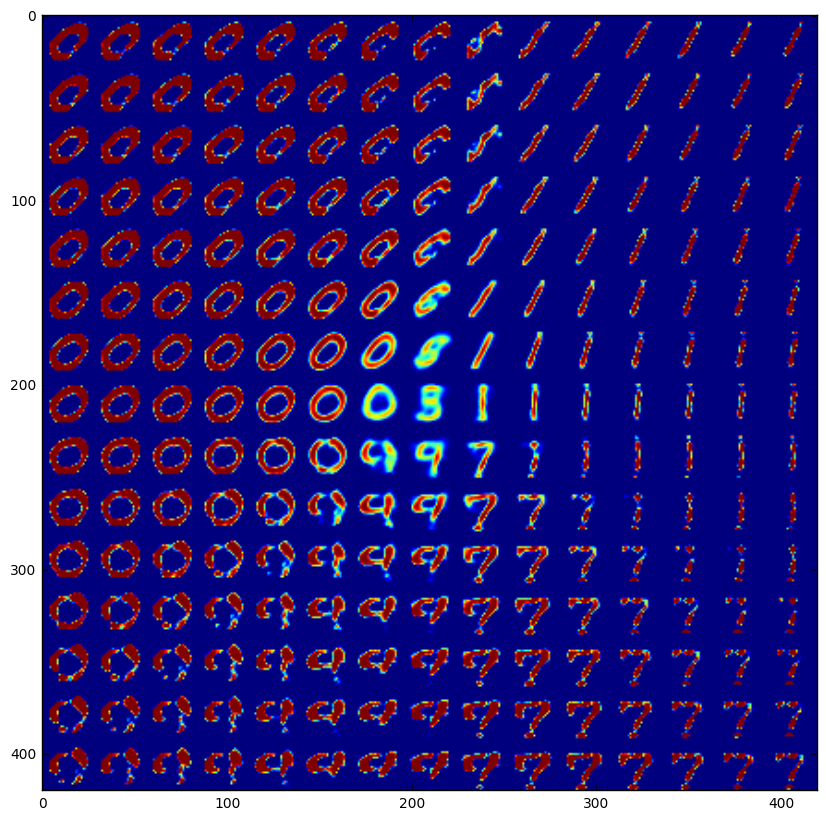

In [46]:
# ====== plotting decoder from latent space =======
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [2]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s - loss: 151.4821 - val_loss: 154.4048
Epoch 2/50
60000/60000 [==============================] - 4s - loss: 151.3928 - val_loss: 154.2647
Epoch 3/50
60000/60000 [==============================] - 4s - loss: 151.2885 - val_loss: 154.4166
Epoch 4/50
60000/60000 [==============================] - 4s - loss: 151.2405 - val_loss: 154.5459
Epoch 5/50
60000/60000 [==============================] - 4s - loss: 151.0592 - val_loss: 154.2597
Epoch 6/50
60000/60000 [==============================] - 4s - loss: 150.9591 - val_loss: 154.1939
Epoch 7/50
60000/60000 [==============================] - 4s - loss: 150.8816 - val_loss: 154.3930
Epoch 8/50
60000/60000 [==============================] - 4s - loss: 150.7815 - val_loss: 154.1833
Epoch 9/50
60000/60000 [==============================] - 4s - loss: 150.7017 - val_loss: 154.0871
Epoch 10/50
60000/60000 [==============================] - 

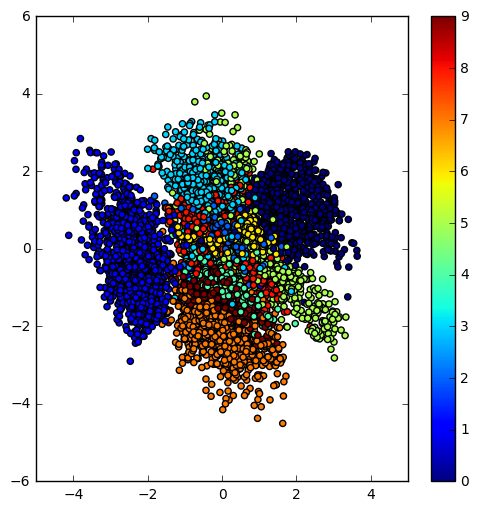

In [3]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

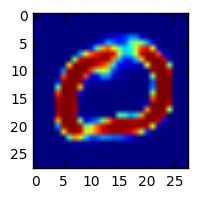

In [30]:
def draw_digit(z_sample, digit_size = 28, n=1):
    z_sample = np.array(z_sample).reshape(1,2)
    figure = np.zeros((digit_size * n, digit_size * n))
    x_decoded = generator.predict(z_sample)
    digit = x_decoded[0].reshape(digit_size, digit_size)
    i, j = 0,0
    figure[i * digit_size: (i + 1) * digit_size,
           j * digit_size: (j + 1) * digit_size] = digit
    plt.figure(figsize=(2, 2))
    plt.imshow(figure)
    plt.show()
    
draw_digit((4,4))

In [14]:
np.array([[-3,0]]).shape

(1, 2)

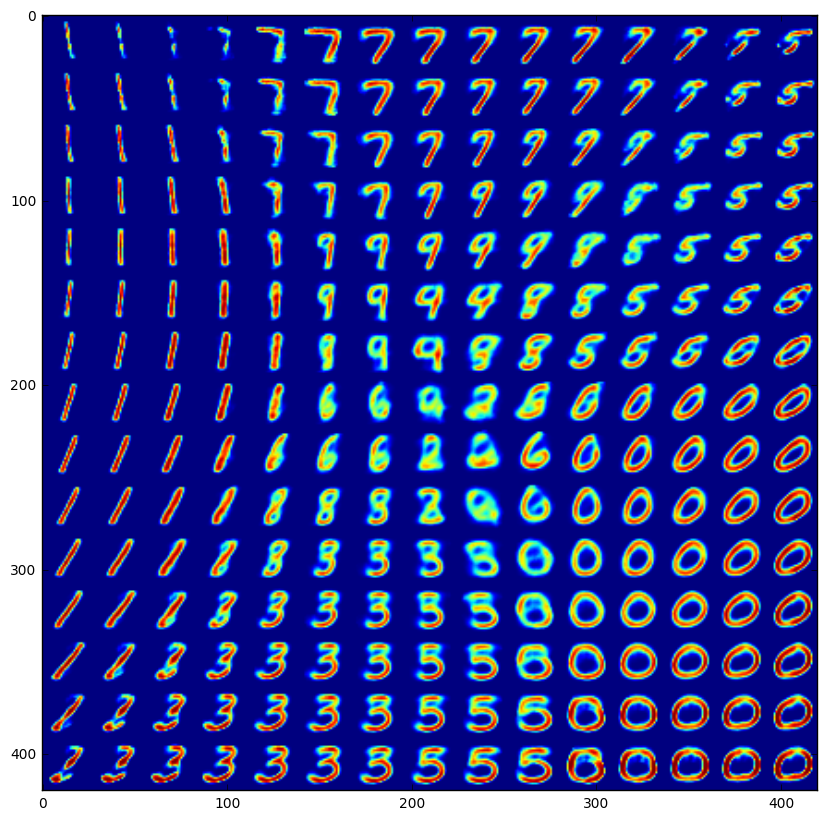

In [33]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
ss = 3
grid_x = np.linspace(-ss, ss, n)
grid_y = np.linspace(-ss, ss, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

# Convo VAE

In [ ]:
'''This script demonstrates how to build a variational autoencoder
with Keras and deconvolution layers.

Reference: "Auto-Encoding Variational Bayes" https://arxiv.org/abs/1312.6114
'''
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Flatten, Reshape
from keras.layers import Convolution2D, Deconvolution2D
from keras.models import Model
from keras import backend as K
from keras import objectives
from keras.datasets import mnist

def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(batch_size, latent_dim),
                              mean=0., std=epsilon_std)
    return z_mean + K.exp(z_log_var) * epsilon

def vae_loss(x, x_decoded_mean):
    # NOTE: binary_crossentropy expects a batch_size by dim
    # for x and x_decoded_mean, so we MUST flatten these!
    x = K.flatten(x)
    x_decoded_mean = K.flatten(x_decoded_mean)
    xent_loss = img_rows * img_cols * objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    return xent_loss + kl_loss


# input image dimensions
img_rows, img_cols, img_chns = 28, 28, 1
# number of convolutional filters to use
nb_filters = 64
# convolution kernel size
nb_conv = 3

batch_size = 100
if K.image_dim_ordering() == 'th':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)
latent_dim = 2
intermediate_dim = 128
epsilon_std = 1.0
nb_epoch = 5

x = Input(batch_shape=(batch_size,) + original_img_size)
conv_1 = Convolution2D(img_chns, 2, 2, border_mode='same', activation='relu')(x)
conv_2 = Convolution2D(nb_filters, 2, 2,
                       border_mode='same', activation='relu',
                       subsample=(2, 2))(conv_1)
conv_3 = Convolution2D(nb_filters, nb_conv, nb_conv,
                       border_mode='same', activation='relu',
                       subsample=(1, 1))(conv_2)
conv_4 = Convolution2D(nb_filters, nb_conv, nb_conv,
                       border_mode='same', activation='relu',
                       subsample=(1, 1))(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)




# note that "output_shape" isn't necessary with the TensorFlow backend
# so you could write `Lambda(sampling)([z_mean, z_log_var])`
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

# we instantiate these layers separately so as to reuse them later
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(nb_filters * 14 * 14, activation='relu')

if K.image_dim_ordering() == 'th':
    output_shape = (batch_size, nb_filters, 14, 14)
else:
    output_shape = (batch_size, 14, 14, nb_filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Deconvolution2D(nb_filters, nb_conv, nb_conv,
                                   output_shape,
                                   border_mode='same',
                                   subsample=(1, 1),
                                   activation='relu')
decoder_deconv_2 = Deconvolution2D(nb_filters, nb_conv, nb_conv,
                                   output_shape,
                                   border_mode='same',
                                   subsample=(1, 1),
                                   activation='relu')
if K.image_dim_ordering() == 'th':
    output_shape = (batch_size, nb_filters, 29, 29)
else:
    output_shape = (batch_size, 29, 29, nb_filters)
decoder_deconv_3_upsamp = Deconvolution2D(nb_filters, 2, 2,
                                          output_shape,
                                          border_mode='valid',
                                          subsample=(2, 2),
                                          activation='relu')
decoder_mean_squash = Convolution2D(img_chns, 2, 2,
                                    border_mode='valid',
                                    activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


vae = Model(x, x_decoded_mean_squash)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

print('x_train.shape:', x_train.shape)

In [ ]:
vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

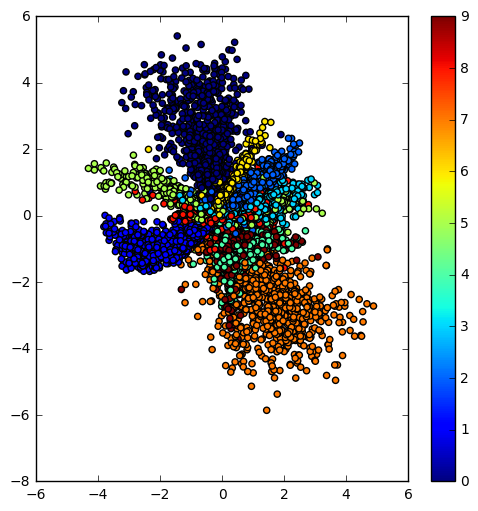

In [35]:
# build a model to project inputs on the latent space
encoder = Model(x, z_mean)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_9 (InputLayer)             (100, 28, 28, 1)      0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (100, 28, 28, 1)      5           input_9[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (100, 14, 14, 64)     320         convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_3 (Convolution2D)  (100, 14, 14, 64)     36928       convolution2d_2[0][0]            
___________________________________________________________________________________________

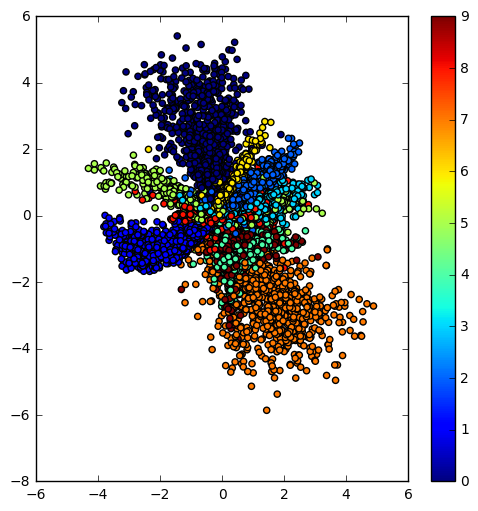

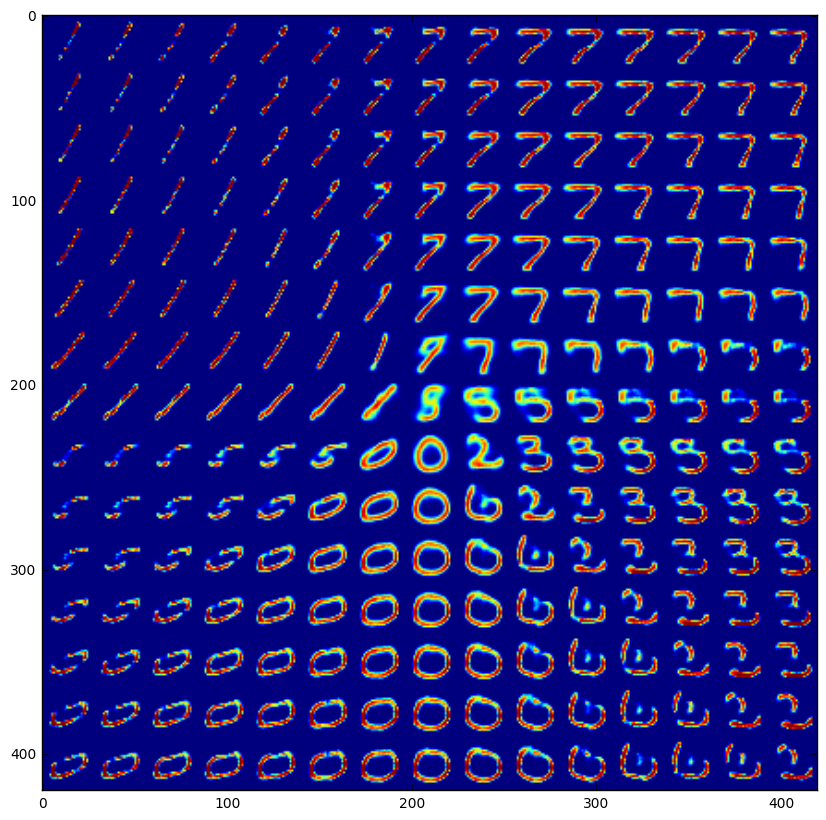

In [34]:
# build a digit generator that can sample from the learned distribution
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = generator.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()